In [24]:
# Importing Libraries

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import issparse

# scikit-learn
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

sns.set(style="whitegrid")
%matplotlib inline

In [26]:
# Loading & Preprocessing Each Dataset


# 1) ADULT DATASET
adult = pd.read_csv("adult.csv").replace("?", np.nan)
adult.dropna(inplace=True)
# Binarize income
adult['income'] = adult['income'].apply(lambda x: 1 if '>50K' in x else 0)
X_adult = pd.get_dummies(adult.drop('income', axis=1), drop_first=True)
y_adult = adult['income']
X_train_adult, X_test_adult, y_train_adult, y_test_adult = train_test_split(
    X_adult, y_adult, test_size=0.3, random_state=42
)

# 2) COMPAS DATASET
compas = pd.read_csv("compas-scores-raw.csv")
compas = compas[['Sex_Code_Text','Ethnic_Code_Text','DecileScore']].dropna()
compas['DecileScore'] = (compas['DecileScore'] >= 5).astype(int)
X_compas = pd.get_dummies(compas[['Sex_Code_Text','Ethnic_Code_Text']], drop_first=True)
y_compas = compas['DecileScore']
X_train_compas, X_test_compas, y_train_compas, y_test_compas = train_test_split(
    X_compas, y_compas, test_size=0.3, random_state=42
)

# 3) CROWS-PAIRS
crows = pd.read_csv("crows_pairs_.csv").dropna()
crows['target'] = (crows['stereo_antistereo'] == 'stereo').astype(int)
tfidf_crows = TfidfVectorizer(max_features=5000)
X_crows = tfidf_crows.fit_transform(crows['sent_more'])
y_crows = crows['target']
X_train_crows, X_test_crows, y_train_crows, y_test_crows = train_test_split(
    X_crows, y_crows, test_size=0.3, random_state=42
)

# 4) HATE SPEECH
hate = pd.read_csv("hate_speech_and_offensive_language_dataset.csv").dropna()
hate['label'] = hate['class'].apply(lambda x: 1 if x>0 else 0)
tfidf_hate = TfidfVectorizer(max_features=5000)
X_hate = tfidf_hate.fit_transform(hate['tweet'])
y_hate = hate['label']
X_train_hate, X_test_hate, y_train_hate, y_test_hate = train_test_split(
    X_hate, y_hate, test_size=0.3, random_state=42
)

# 5) JIGSAW
jigsaw = pd.read_csv("jigsaw_unintended_bias_in_toxicity_all_data.csv").dropna()
jigsaw['label'] = (jigsaw['toxicity_annotator_count']>10).astype(int)
tfidf_jigsaw = TfidfVectorizer(max_features=5000)
X_jigsaw = tfidf_jigsaw.fit_transform(jigsaw['comment_text'])
y_jigsaw = jigsaw['label']
X_train_jigsaw, X_test_jigsaw, y_train_jigsaw, y_test_jigsaw = train_test_split(
    X_jigsaw, y_jigsaw, test_size=0.3, random_state=42
)

# Combine into a dictionary with dataset type
datasets = {
    "Adult": {
        "data": (X_train_adult, X_test_adult, y_train_adult, y_test_adult),
        "type": "numeric"
    },
    "COMPAS": {
        "data": (X_train_compas, X_test_compas, y_train_compas, y_test_compas),
        "type": "numeric"
    },
    "CrowS-Pairs": {
        "data": (X_train_crows, X_test_crows, y_train_crows, y_test_crows),
        "type": "text"
    },
    "Hate-Speech": {
        "data": (X_train_hate, X_test_hate, y_train_hate, y_test_hate),
        "type": "text"
    },
    "Jigsaw": {
        "data": (X_train_jigsaw, X_test_jigsaw, y_train_jigsaw, y_test_jigsaw),
        "type": "text"
    },
}

In [28]:
# Scaling for Numeric Datasets (Adult, COMPAS)

for dname, info in datasets.items():
    X_train, X_test, y_train, y_test = info["data"]
    if info["type"] == "numeric":
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        datasets[dname]["data"] = (X_train_scaled, X_test_scaled, y_train, y_test)

In [30]:
# Defining Helper Functions (Training, Predicting, Confusion Matrix)


def train_and_predict(model, X_train, y_train, X_test, model_name=None):
    """
    Trains the given model on X_train and y_train, returns predictions on X_test.
    If model is Naive Bayes for text data, ensures data is dense.
    """
    if model_name == "Multinomial Naive Bayes" and issparse(X_train):
       
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    elif model_name == "Gaussian Naive Bayes" and issparse(X_train):
        # Converting to dense for GaussianNB
        X_train_dense = X_train.toarray()
        X_test_dense = X_test.toarray()
        model.fit(X_train_dense, y_train)
        y_pred = model.predict(X_test_dense)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    return y_pred

def plot_confusion_matrix_and_report(y_true, y_pred, dataset_name, model_name):
    """
    Plots the confusion matrix and prints classification metrics.
    """
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n=== {model_name} on {dataset_name} ===")
    print("Confusion Matrix:\n", cm)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_name} - {dataset_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

In [32]:
# Defining Classifiers

# Defining classifiers for numeric and text datasets separately
classifiers_numeric = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver='saga', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel="linear", probability=True, max_iter=2000, random_state=42),
    "Gaussian Naive Bayes": GaussianNB()
}

classifiers_text = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver='saga', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel="linear", probability=True, max_iter=2000, random_state=42),
    "Multinomial Naive Bayes": MultinomialNB()
}


DATASET: Adult (numeric)
--> Training & Evaluating: Logistic Regression

=== Logistic Regression on Adult ===
Confusion Matrix:
 [[9508  733]
 [1302 2024]]


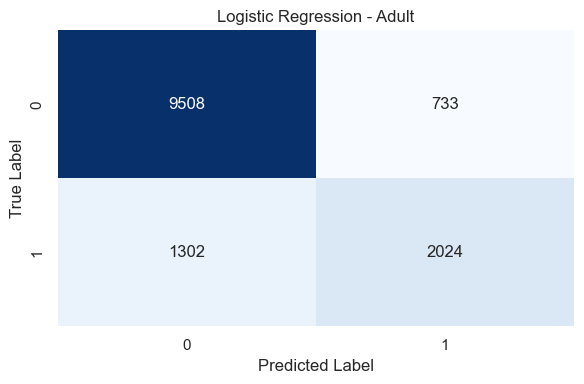

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10241
           1       0.73      0.61      0.67      3326

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.78     13567
weighted avg       0.84      0.85      0.85     13567

--> Training & Evaluating: Decision Tree

=== Decision Tree on Adult ===
Confusion Matrix:
 [[8888 1353]
 [1269 2057]]


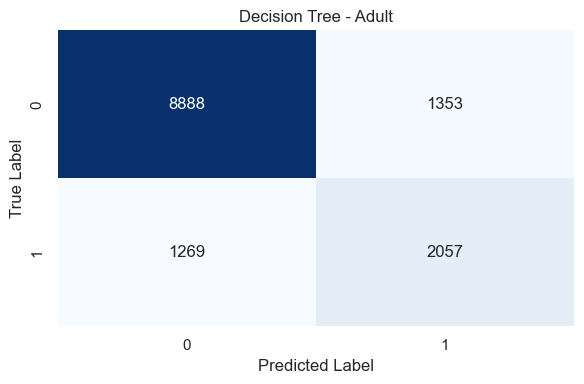

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     10241
           1       0.60      0.62      0.61      3326

    accuracy                           0.81     13567
   macro avg       0.74      0.74      0.74     13567
weighted avg       0.81      0.81      0.81     13567

--> Training & Evaluating: Random Forest

=== Random Forest on Adult ===
Confusion Matrix:
 [[9473  768]
 [1251 2075]]


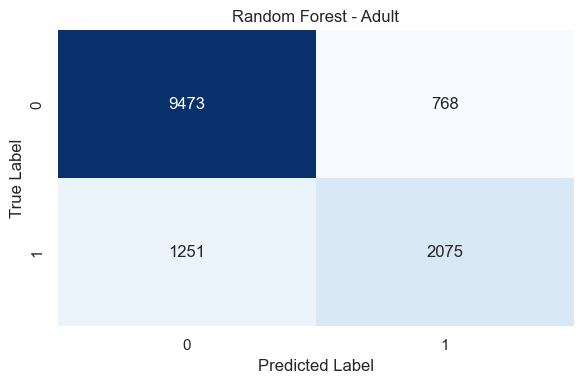

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10241
           1       0.73      0.62      0.67      3326

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.79     13567
weighted avg       0.85      0.85      0.85     13567

--> Training & Evaluating: SVM

=== SVM on Adult ===
Confusion Matrix:
 [[4087 6154]
 [1264 2062]]


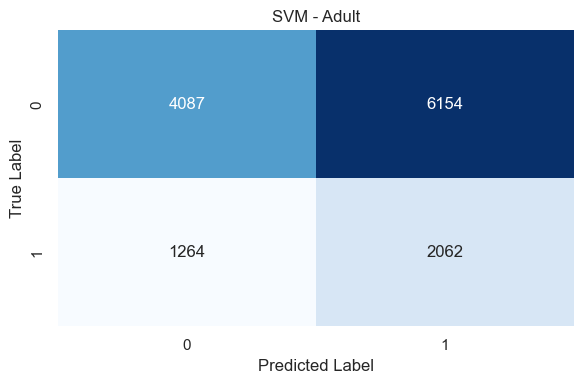

Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.40      0.52     10241
           1       0.25      0.62      0.36      3326

    accuracy                           0.45     13567
   macro avg       0.51      0.51      0.44     13567
weighted avg       0.64      0.45      0.48     13567

--> Training & Evaluating: Gaussian Naive Bayes

=== Gaussian Naive Bayes on Adult ===
Confusion Matrix:
 [[4592 5649]
 [ 202 3124]]


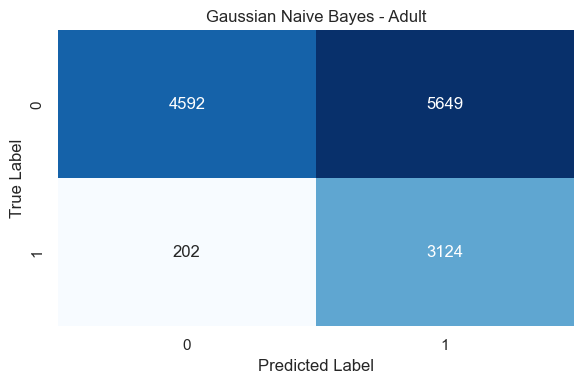

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.45      0.61     10241
           1       0.36      0.94      0.52      3326

    accuracy                           0.57     13567
   macro avg       0.66      0.69      0.56     13567
weighted avg       0.81      0.57      0.59     13567


DATASET: COMPAS (numeric)
--> Training & Evaluating: Logistic Regression

=== Logistic Regression on COMPAS ===
Confusion Matrix:
 [[12440     5]
 [ 5802     6]]


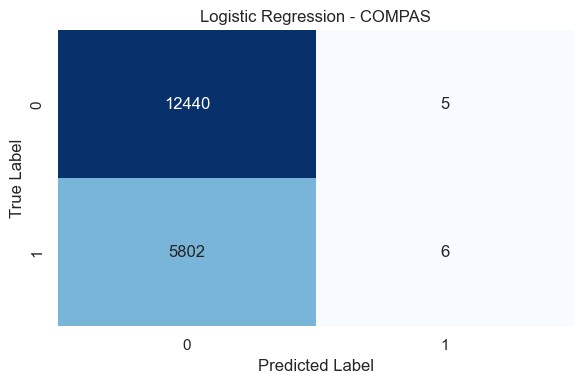

Classification Report:

              precision    recall  f1-score   support

           0       0.68      1.00      0.81     12445
           1       0.55      0.00      0.00      5808

    accuracy                           0.68     18253
   macro avg       0.61      0.50      0.41     18253
weighted avg       0.64      0.68      0.55     18253

--> Training & Evaluating: Decision Tree

=== Decision Tree on COMPAS ===
Confusion Matrix:
 [[12440     5]
 [ 5802     6]]


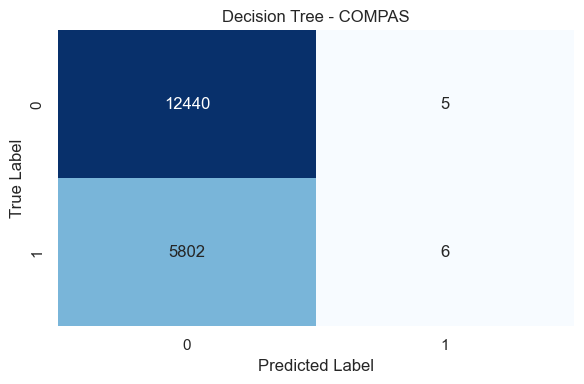

Classification Report:

              precision    recall  f1-score   support

           0       0.68      1.00      0.81     12445
           1       0.55      0.00      0.00      5808

    accuracy                           0.68     18253
   macro avg       0.61      0.50      0.41     18253
weighted avg       0.64      0.68      0.55     18253

--> Training & Evaluating: Random Forest

=== Random Forest on COMPAS ===
Confusion Matrix:
 [[12440     5]
 [ 5802     6]]


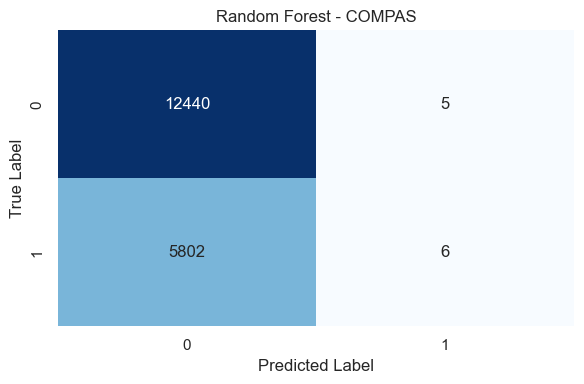

Classification Report:

              precision    recall  f1-score   support

           0       0.68      1.00      0.81     12445
           1       0.55      0.00      0.00      5808

    accuracy                           0.68     18253
   macro avg       0.61      0.50      0.41     18253
weighted avg       0.64      0.68      0.55     18253

--> Training & Evaluating: SVM

=== SVM on COMPAS ===
Confusion Matrix:
 [[2906 9539]
 [1046 4762]]


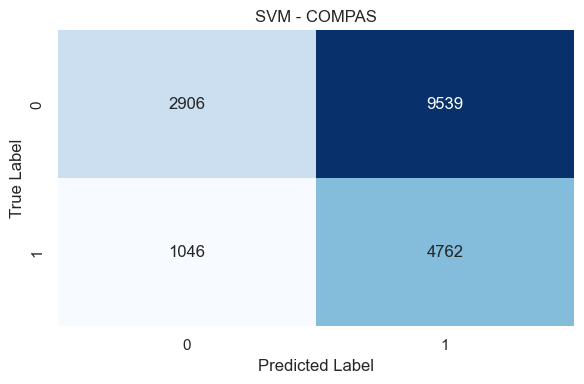

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.23      0.35     12445
           1       0.33      0.82      0.47      5808

    accuracy                           0.42     18253
   macro avg       0.53      0.53      0.41     18253
weighted avg       0.61      0.42      0.39     18253

--> Training & Evaluating: Gaussian Naive Bayes

=== Gaussian Naive Bayes on COMPAS ===
Confusion Matrix:
 [[4032 8413]
 [1059 4749]]


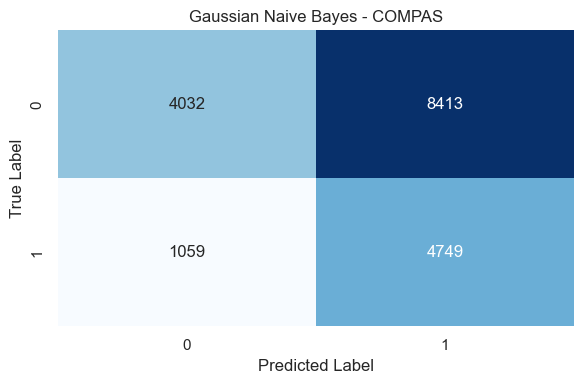

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.32      0.46     12445
           1       0.36      0.82      0.50      5808

    accuracy                           0.48     18253
   macro avg       0.58      0.57      0.48     18253
weighted avg       0.65      0.48      0.47     18253


DATASET: CrowS-Pairs (text)
--> Training & Evaluating: Logistic Regression

=== Logistic Regression on CrowS-Pairs ===
Confusion Matrix:
 [[  0  68]
 [  0 385]]


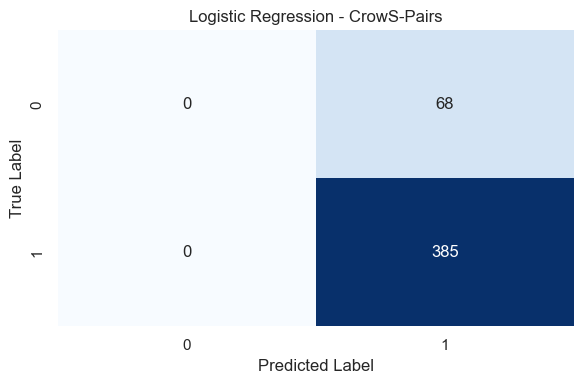

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.85      1.00      0.92       385

    accuracy                           0.85       453
   macro avg       0.42      0.50      0.46       453
weighted avg       0.72      0.85      0.78       453

--> Training & Evaluating: Decision Tree

=== Decision Tree on CrowS-Pairs ===
Confusion Matrix:
 [[ 13  55]
 [ 39 346]]


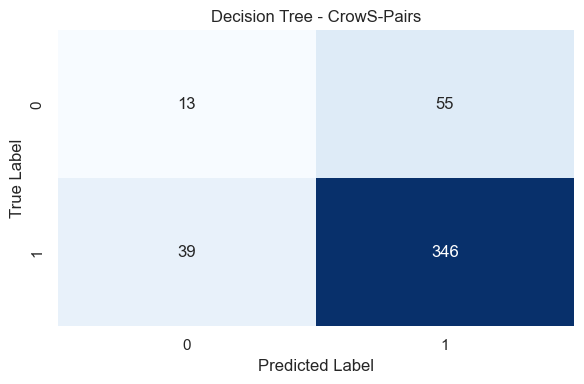

Classification Report:

              precision    recall  f1-score   support

           0       0.25      0.19      0.22        68
           1       0.86      0.90      0.88       385

    accuracy                           0.79       453
   macro avg       0.56      0.54      0.55       453
weighted avg       0.77      0.79      0.78       453

--> Training & Evaluating: Random Forest

=== Random Forest on CrowS-Pairs ===
Confusion Matrix:
 [[  0  68]
 [  0 385]]


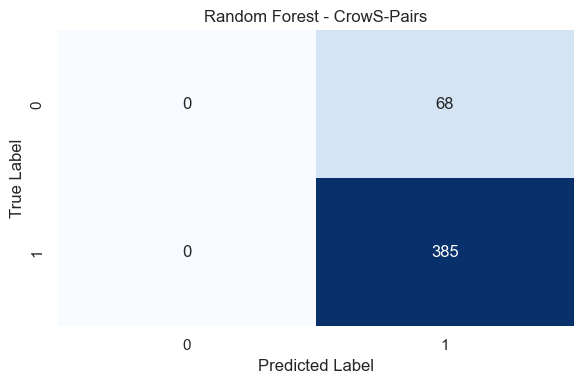

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.85      1.00      0.92       385

    accuracy                           0.85       453
   macro avg       0.42      0.50      0.46       453
weighted avg       0.72      0.85      0.78       453

--> Training & Evaluating: SVM

=== SVM on CrowS-Pairs ===
Confusion Matrix:
 [[  1  67]
 [  0 385]]


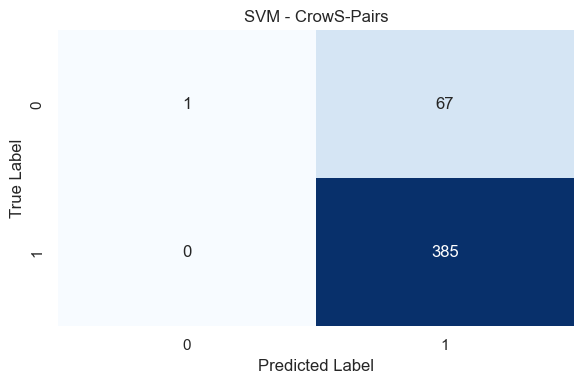

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.01      0.03        68
           1       0.85      1.00      0.92       385

    accuracy                           0.85       453
   macro avg       0.93      0.51      0.47       453
weighted avg       0.87      0.85      0.79       453

--> Training & Evaluating: Multinomial Naive Bayes

=== Multinomial Naive Bayes on CrowS-Pairs ===
Confusion Matrix:
 [[  0  68]
 [  0 385]]


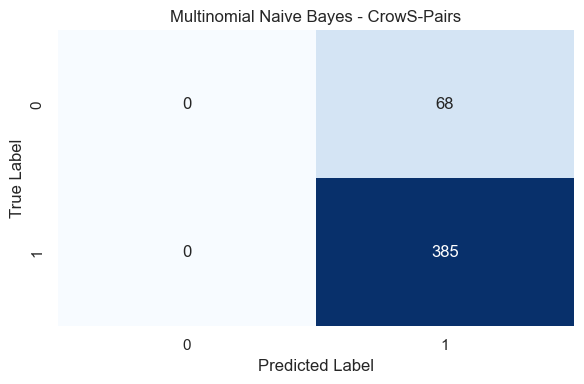

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.85      1.00      0.92       385

    accuracy                           0.85       453
   macro avg       0.42      0.50      0.46       453
weighted avg       0.72      0.85      0.78       453


DATASET: Hate-Speech (text)
--> Training & Evaluating: Logistic Regression

=== Logistic Regression on Hate-Speech ===
Confusion Matrix:
 [[  32  395]
 [  32 6976]]


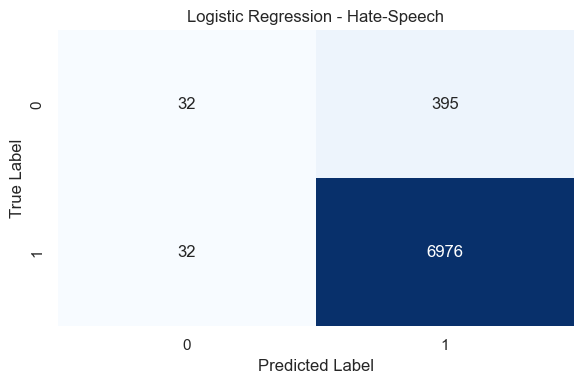

Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.07      0.13       427
           1       0.95      1.00      0.97      7008

    accuracy                           0.94      7435
   macro avg       0.72      0.54      0.55      7435
weighted avg       0.92      0.94      0.92      7435

--> Training & Evaluating: Decision Tree

=== Decision Tree on Hate-Speech ===
Confusion Matrix:
 [[ 120  307]
 [ 283 6725]]


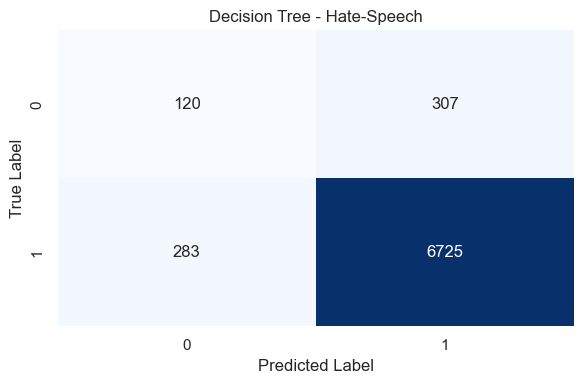

Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.28      0.29       427
           1       0.96      0.96      0.96      7008

    accuracy                           0.92      7435
   macro avg       0.63      0.62      0.62      7435
weighted avg       0.92      0.92      0.92      7435

--> Training & Evaluating: Random Forest

=== Random Forest on Hate-Speech ===
Confusion Matrix:
 [[  54  373]
 [  52 6956]]


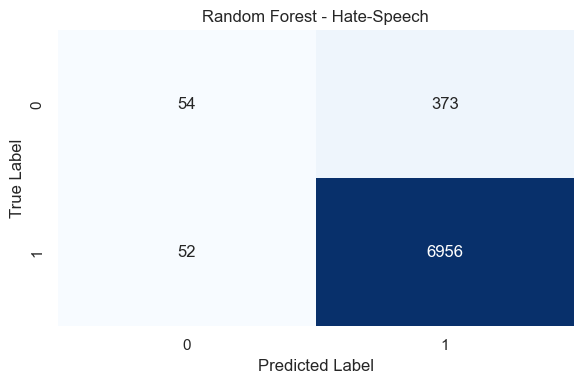

Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.13      0.20       427
           1       0.95      0.99      0.97      7008

    accuracy                           0.94      7435
   macro avg       0.73      0.56      0.59      7435
weighted avg       0.92      0.94      0.93      7435

--> Training & Evaluating: SVM

=== SVM on Hate-Speech ===
Confusion Matrix:
 [[  41  386]
 [  31 6977]]


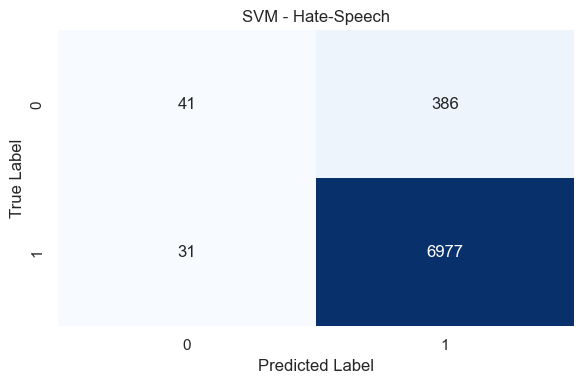

Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.10      0.16       427
           1       0.95      1.00      0.97      7008

    accuracy                           0.94      7435
   macro avg       0.76      0.55      0.57      7435
weighted avg       0.93      0.94      0.92      7435

--> Training & Evaluating: Multinomial Naive Bayes

=== Multinomial Naive Bayes on Hate-Speech ===
Confusion Matrix:
 [[   1  426]
 [   3 7005]]


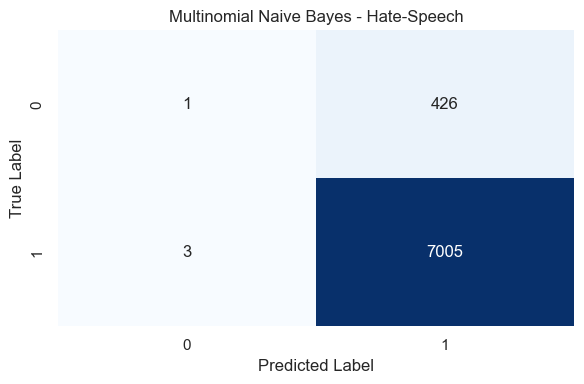

Classification Report:

              precision    recall  f1-score   support

           0       0.25      0.00      0.00       427
           1       0.94      1.00      0.97      7008

    accuracy                           0.94      7435
   macro avg       0.60      0.50      0.49      7435
weighted avg       0.90      0.94      0.91      7435


DATASET: Jigsaw (text)
--> Training & Evaluating: Logistic Regression

=== Logistic Regression on Jigsaw ===
Confusion Matrix:
 [[73932   238]
 [ 2639  1106]]


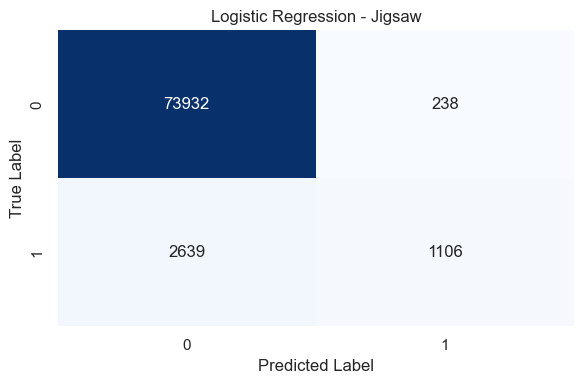

Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     74170
           1       0.82      0.30      0.43      3745

    accuracy                           0.96     77915
   macro avg       0.89      0.65      0.71     77915
weighted avg       0.96      0.96      0.95     77915

--> Training & Evaluating: Decision Tree

=== Decision Tree on Jigsaw ===
Confusion Matrix:
 [[71995  2175]
 [ 2402  1343]]


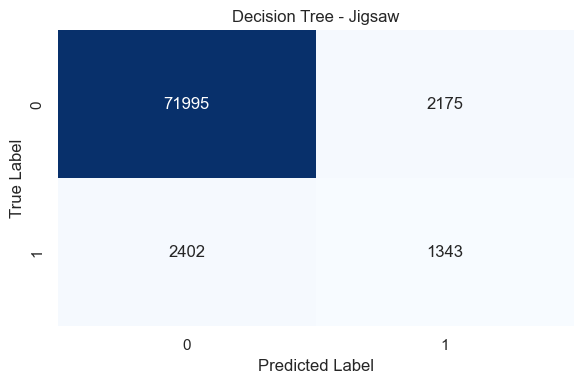

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     74170
           1       0.38      0.36      0.37      3745

    accuracy                           0.94     77915
   macro avg       0.67      0.66      0.67     77915
weighted avg       0.94      0.94      0.94     77915

--> Training & Evaluating: Random Forest

=== Random Forest on Jigsaw ===
Confusion Matrix:
 [[73971   199]
 [ 2971   774]]


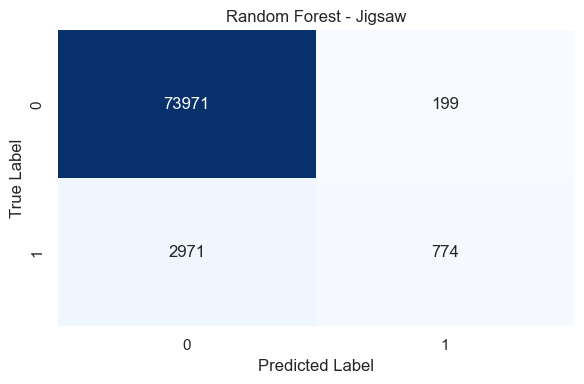

Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     74170
           1       0.80      0.21      0.33      3745

    accuracy                           0.96     77915
   macro avg       0.88      0.60      0.65     77915
weighted avg       0.95      0.96      0.95     77915

--> Training & Evaluating: SVM

=== SVM on Jigsaw ===
Confusion Matrix:
 [[59361 14809]
 [ 1673  2072]]


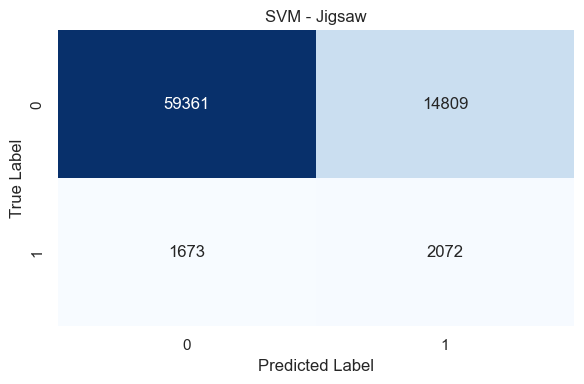

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     74170
           1       0.12      0.55      0.20      3745

    accuracy                           0.79     77915
   macro avg       0.55      0.68      0.54     77915
weighted avg       0.93      0.79      0.85     77915

--> Training & Evaluating: Multinomial Naive Bayes

=== Multinomial Naive Bayes on Jigsaw ===
Confusion Matrix:
 [[74168     2]
 [ 3653    92]]


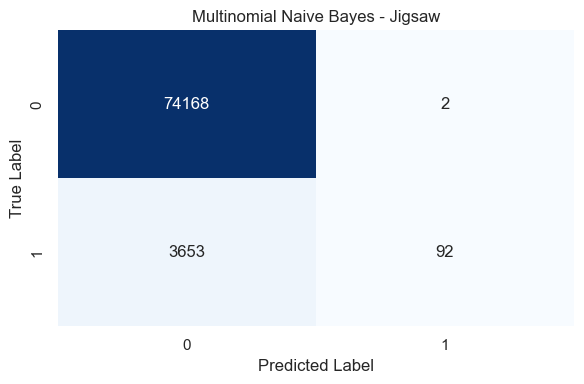

Classification Report:

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     74170
           1       0.98      0.02      0.05      3745

    accuracy                           0.95     77915
   macro avg       0.97      0.51      0.51     77915
weighted avg       0.95      0.95      0.93     77915



In [34]:
# Training Five Algorithms & Collecting Results


# Initialize list to store results
results_list = []

# Iterating over each dataset
for dataset_name, info in datasets.items():
    X_train, X_test, y_train, y_test = info["data"]
    dataset_type = info["type"]
    
    print(f"\n{'='*70}")
    print(f"DATASET: {dataset_name} ({dataset_type})")
    print(f"{'='*70}")
    
    # Selecting appropriate classifier set
    if dataset_type == "numeric":
        classifiers = classifiers_numeric
    else:
        classifiers = classifiers_text
    
    for model_name, model in classifiers.items():
        print(f"--> Training & Evaluating: {model_name}")
        y_pred = train_and_predict(model, X_train, y_train, X_test, model_name=model_name)
        
        # Plotting confusion matrix & classification report
        plot_confusion_matrix_and_report(y_test, y_pred, dataset_name, model_name)
        
        # Computing metrics
        acc  = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred, zero_division=0)
        f1   = f1_score(y_test, y_pred, zero_division=0)
        
        # Storing result for summary table
        results_list.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1
        })

In [38]:
# Summarizing results

# Create a DataFrame from results
results_df = pd.DataFrame(results_list)

# Display the DataFrame
print("\n=== Classification Performance Summary ===")
display(results_df)

# Pivot for better readability
pivot_table = results_df.pivot_table(index=["Dataset","Model"], 
                                     values=["Accuracy","Precision","Recall","F1-Score"])
print("\n=== Summary Pivot Table (Metrics) ===")
display(pivot_table)


=== Classification Performance Summary ===


,Dataset,Model,Accuracy,Precision,Recall,F1-Score
0,Adult,Logistic Regression,0.850004,0.734131,0.608539,0.665461
1,Adult,Decision Tree,0.806737,0.603226,0.618461,0.610748
2,Adult,Random Forest,0.851183,0.729863,0.623873,0.672718
3,Adult,SVM,0.453232,0.250974,0.619964,0.357304
4,Adult,Gaussian Naive Bayes,0.568733,0.356093,0.939266,0.516406
5,COMPAS,Logistic Regression,0.681861,0.545455,0.001033,0.002062
6,COMPAS,Decision Tree,0.681861,0.545455,0.001033,0.002062
7,COMPAS,Random Forest,0.681861,0.545455,0.001033,0.002062
8,COMPAS,SVM,0.420095,0.332984,0.819904,0.473619
9,COMPAS,Gaussian Naive Bayes,0.481072,0.360811,0.817665,0.500685



=== Summary Pivot Table (Metrics) ===


Accuracy  F1-Score  Precision    Recall
Dataset     Model                                                           
Adult       Decision Tree            0.806737  0.610748   0.603226  0.618461
            Gaussian Naive Bayes     0.568733  0.516406   0.356093  0.939266
            Logistic Regression      0.850004  0.665461   0.734131  0.608539
            Random Forest            0.851183  0.672718   0.729863  0.623873
            SVM                      0.453232  0.357304   0.250974  0.619964
COMPAS      Decision Tree            0.681861  0.002062   0.545455  0.001033
            Gaussian Naive Bayes     0.481072  0.500685   0.360811  0.817665
            Logistic Regression      0.681861  0.002062   0.545455  0.001033
            Random Forest            0.681861  0.002062   0.545455  0.001033
            SVM                      0.420095  0.473619   0.332984  0.819904
CrowS-Pairs Decision Tree            0.792494  0.880407   0.862843  0.898701
            Logistic Regression      0.849890  0.918854   0.849890  1.000000
            Multinomial Naive Bayes  0.849890  0.918854   0.849890  1.000000
            Random Forest            0.849890  0.918854   0.849890  1.000000
            SVM                      0.852097  0.919952   0.851770  1.000000
Hate-Speech Decision Tree            0.920646  0.957977   0.956342  0.959618
            Logistic Regression      0.942569  0.970304   0.946412  0.995434
            Multinomial Naive Bayes  0.942300  0.970289   0.942673  0.999572
            Random Forest            0.942838  0.970356   0.949106  0.992580
            SVM                      0.943914  0.970983   0.947576  0.995576
Jigsaw      Decision Tree            0.941256  0.369820   0.381751  0.358611
            Logistic Regression      0.963075  0.434663   0.822917  0.295327
            Multinomial Naive Bayes  0.953090  0.047929   0.978723  0.024566
            Random Forest            0.959315  0.328105   0.795478  0.206676
            SVM                      0.788462  0.200911   0.122742  0.553271

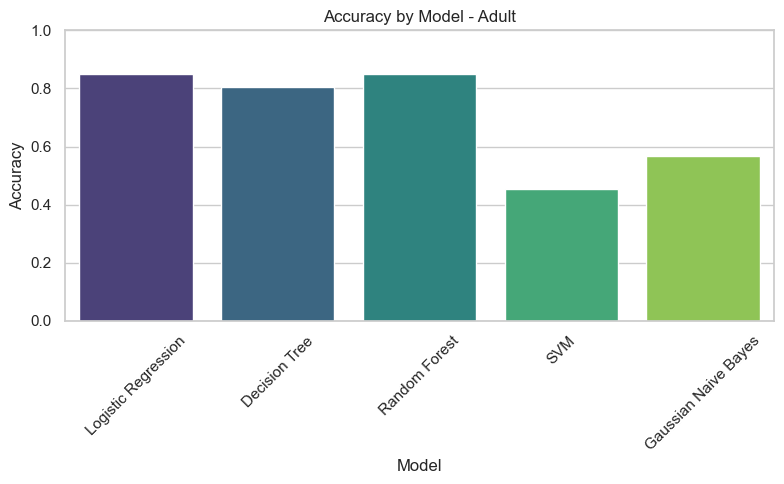

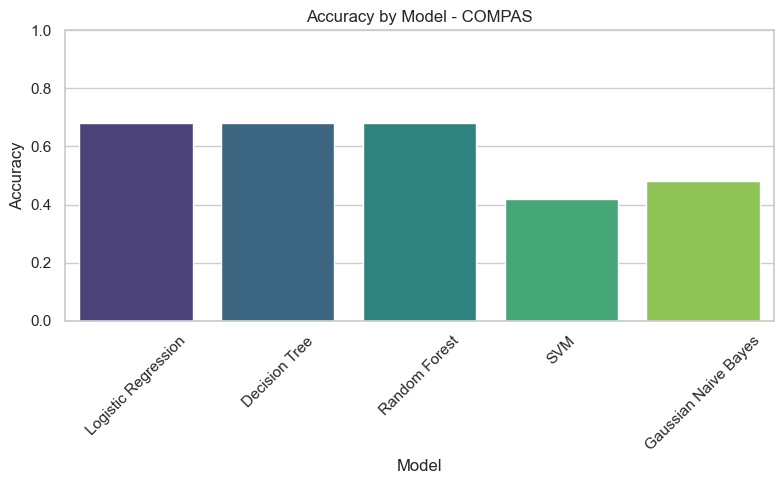

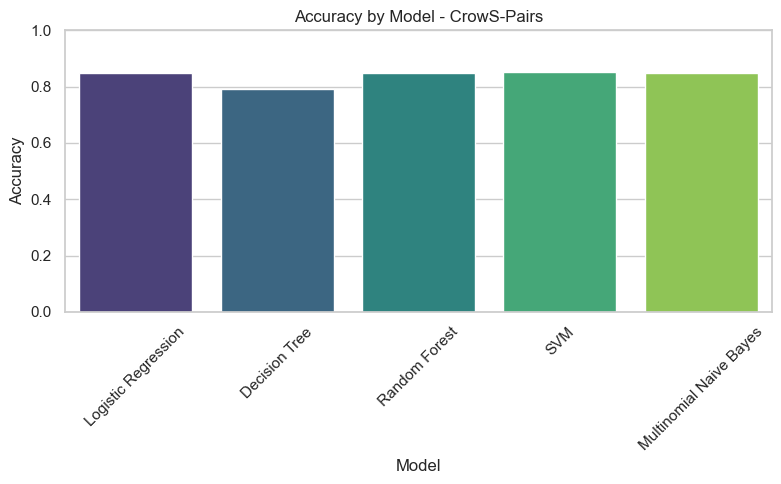

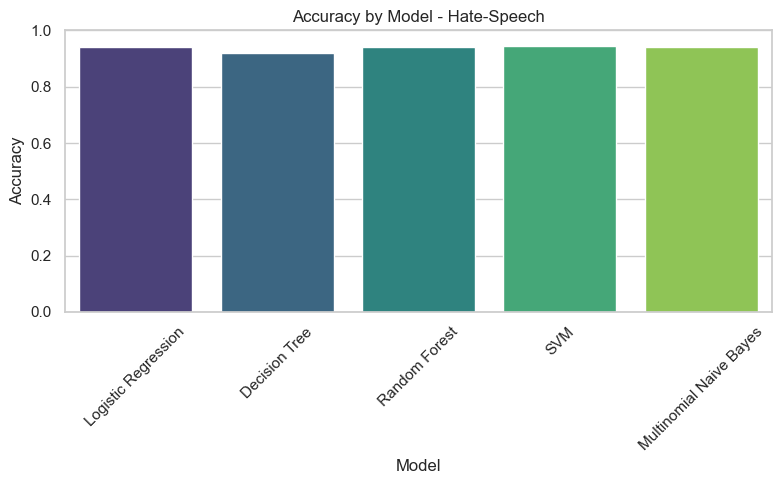

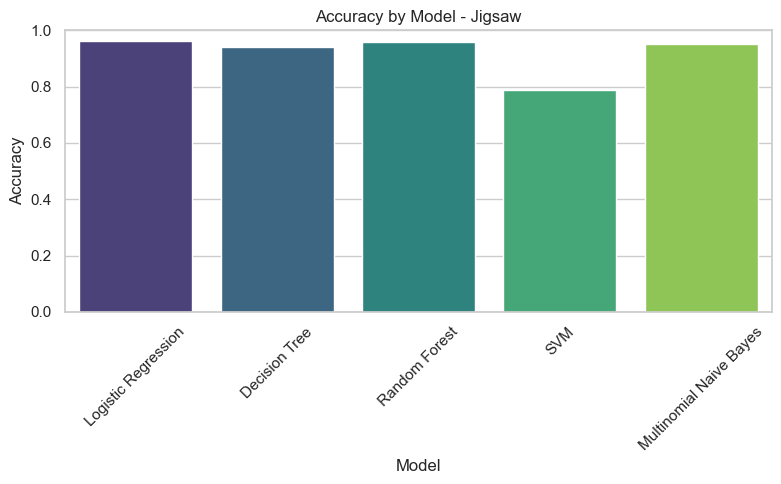

In [44]:
# Plotting Accuracy by Model for each Dataset

for dataset_name in results_df['Dataset'].unique():
    subset = results_df[results_df['Dataset'] == dataset_name]
    
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x='Model', y='Accuracy', hue='Model', data=subset, 
        palette=sns.color_palette('viridis', len(subset['Model'].unique())), dodge=False, legend=False
    )
    plt.ylim(0, 1)
    plt.title(f"Accuracy by Model - {dataset_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


=== ROC Curves for Adult (numeric) ===


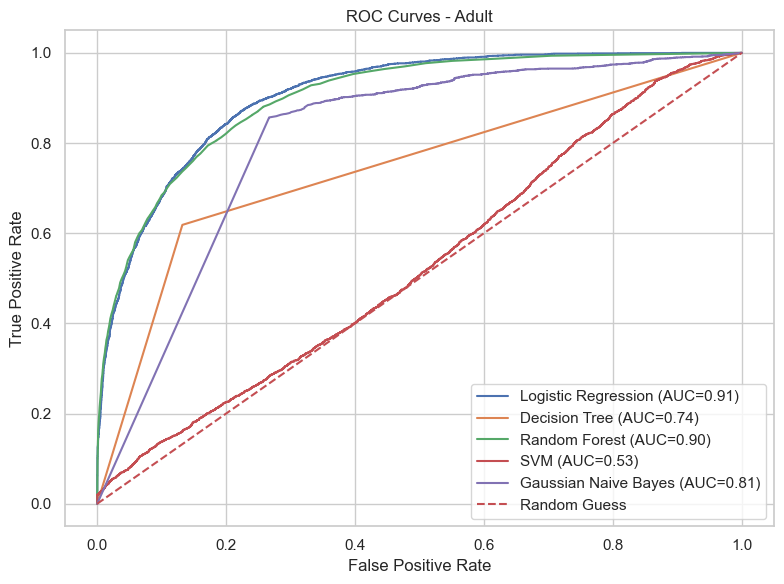


=== ROC Curves for COMPAS (numeric) ===


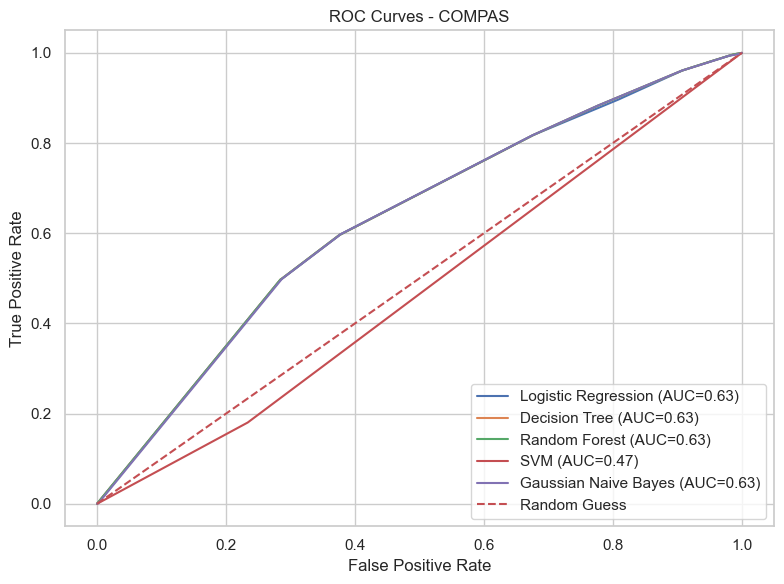


=== ROC Curves for CrowS-Pairs (text) ===


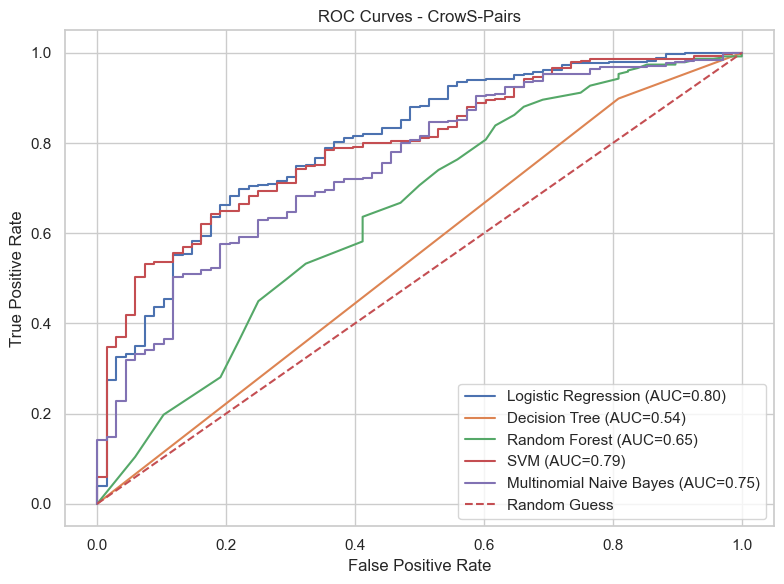


=== ROC Curves for Hate-Speech (text) ===


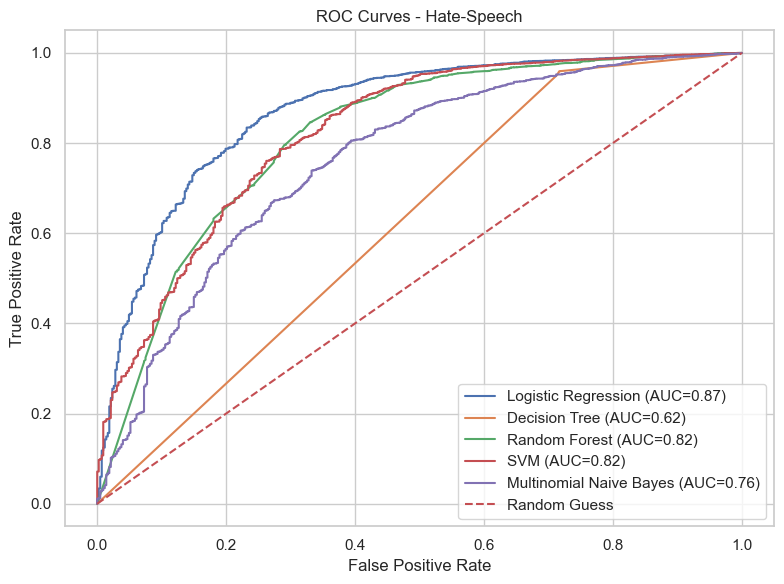


=== ROC Curves for Jigsaw (text) ===


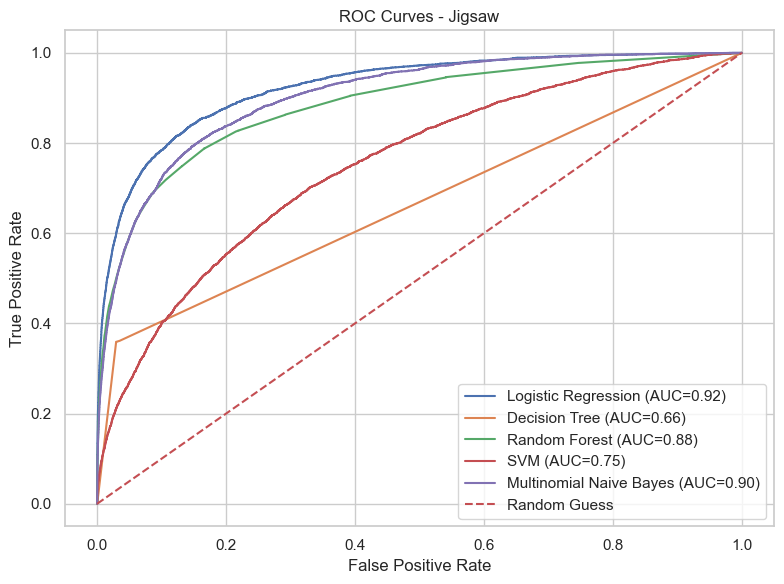

In [46]:
# ROC Curves

def plot_roc_curves(models, X_test, y_test, dname):
    """
    Plots ROC curves for the provided models on the given dataset.
    """
    plt.figure(figsize=(8,6))
    for model_name, fitted_model in models.items():
        if hasattr(fitted_model, "predict_proba"):
            if model_name in ["Multinomial Naive Bayes"]:
                y_prob = fitted_model.predict_proba(X_test)[:,1]
            else:
                y_prob = fitted_model.predict_proba(X_test)[:,1]
            
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc_val = roc_auc_score(y_test, y_prob)
            plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_val:.2f})")
        else:
            print(f"{model_name} does not support predict_proba, skipping ROC curve.")
    
    plt.plot([0,1],[0,1],'r--', label="Random Guess")
    plt.title(f"ROC Curves - {dname}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Re-train models and plot ROC curves
for dataset_name, info in datasets.items():
    X_train, X_test, y_train, y_test = info["data"]
    dataset_type = info["type"]
    
    print(f"\n=== ROC Curves for {dataset_name} ({dataset_type}) ===")
    
    # Select appropriate classifiers
    if dataset_type == "numeric":
        classifiers = classifiers_numeric
    else:
        classifiers = classifiers_text
    
    fitted_models = {}
    for model_name, model in classifiers.items():
        if model_name == "Multinomial Naive Bayes":
            # MultinomialNB can handle sparse data
            model.fit(X_train, y_train)
        elif model_name == "Gaussian Naive Bayes":
            if issparse(X_train):
                model.fit(X_train.toarray(), y_train)
            else:
                model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train)
        fitted_models[model_name] = model
    
    plot_roc_curves(fitted_models, X_test, y_test, dataset_name)


Validation Curve for Random Forest on Adult (numeric)


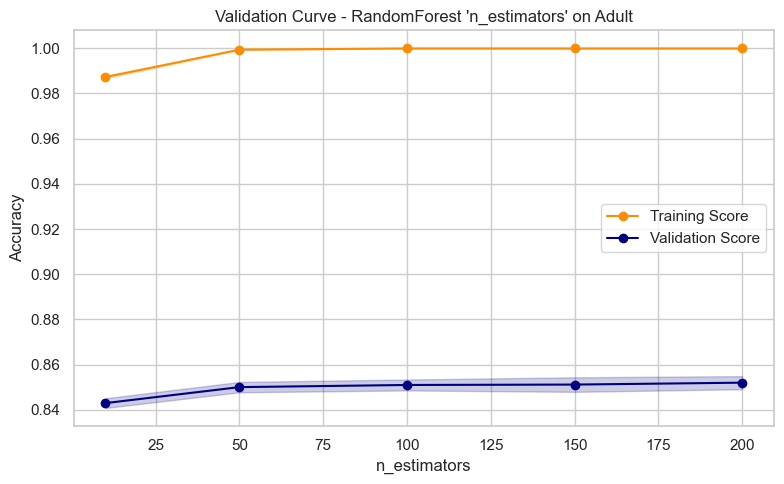


Validation Curve for Random Forest on COMPAS (numeric)


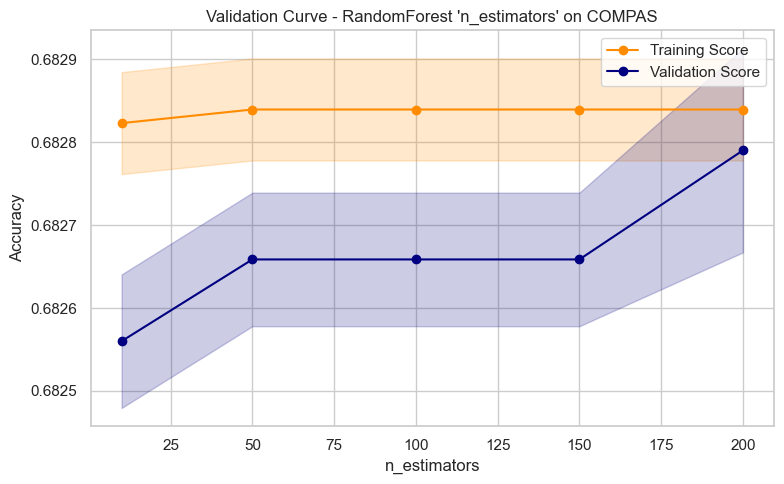

Skipping Validation Curve for CrowS-Pairs (text) - not numeric.
Skipping Validation Curve for Hate-Speech (text) - not numeric.
Skipping Validation Curve for Jigsaw (text) - not numeric.


In [48]:
# Validation Curve


def plot_validation_curve_rf(X, y, dataset_name, param_name="n_estimators", param_range=None, cv=3):
    """
    Plots a validation curve for RandomForest on a chosen hyperparameter.
    """
    if param_range is None:
        param_range = [10, 50, 100, 150, 200]
    
    from sklearn.model_selection import validation_curve
    
    # Converting to dense if needed
    if issparse(X):
        X = X.toarray()
    
    train_scores, test_scores = validation_curve(
        RandomForestClassifier(random_state=42),
        X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring='accuracy', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    test_mean  = np.mean(test_scores, axis=1)
    test_std   = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8,5))
    plt.plot(param_range, train_mean, label="Training Score", color="darkorange", marker='o')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std,
                     alpha=0.2, color="darkorange")
    
    plt.plot(param_range, test_mean, label="Validation Score", color="navy", marker='o')
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std,
                     alpha=0.2, color="navy")
    
    plt.title(f"Validation Curve - RandomForest '{param_name}' on {dataset_name}")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting validation curves for numeric datasets
for dataset_name, info in datasets.items():
    X_train, X_test, y_train, y_test = info["data"]
    dataset_type = info["type"]
    
    if dataset_type == "numeric":
        print(f"\nValidation Curve for Random Forest on {dataset_name} ({dataset_type})")
        # Combine train and test for more data
        X_all = np.vstack((X_train, X_test))
        y_all = np.concatenate((y_train, y_test))
        plot_validation_curve_rf(X_all, y_all, dataset_name, param_name="n_estimators",
                                 param_range=[10,50,100,150,200], cv=3)
    else:
        print(f"Skipping Validation Curve for {dataset_name} ({dataset_type}) - not numeric.")